In [4]:
import requests
from pathlib import Path
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def download_amazon_reviews(base_dir: Path):
    base_url = "https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_"

    with open(base_dir / "metadata.json", "r") as f:
        metadata = json.load(f)


    base_dir.mkdir(parents=True, exist_ok=True)
    for category in metadata:
            category_title = category["category"]
            url = base_url + category_title + ".csv"
            print(f"Downloading {url}")
            r = requests.get(url)
            with open(base_dir / (category_title.lower() + ".csv"), "wb") as f:
                f.write(r.content)

In [3]:
base_dir = Path("data/amazon_reviews")
available = os.listdir(base_dir)
data = []
for file in available:
    if file.endswith(".csv"):
        with open(base_dir / file, "r") as f:
            df = pd.read_csv(f, on_bad_lines="skip", header=None)
            df["category"] = file.replace(".csv", "")
            data.append(df)

df = pd.concat(data)
df.columns = ["user_id", "item_id", "rating", "timestamp", "category"]

KeyboardInterrupt: 

In [ ]:
users_sample_count = 10000
users = df.groupby("user_id").size().sort_values(ascending=False)
users = users[users >= 10]
users = users.sample(users_sample_count)
df = df[df["user_id"].isin(users.index)]

In [ ]:
df["user_id"] = df["user_id"].astype("category").cat.codes
df["item_id"] = df["item_id"].astype("category").cat.codes

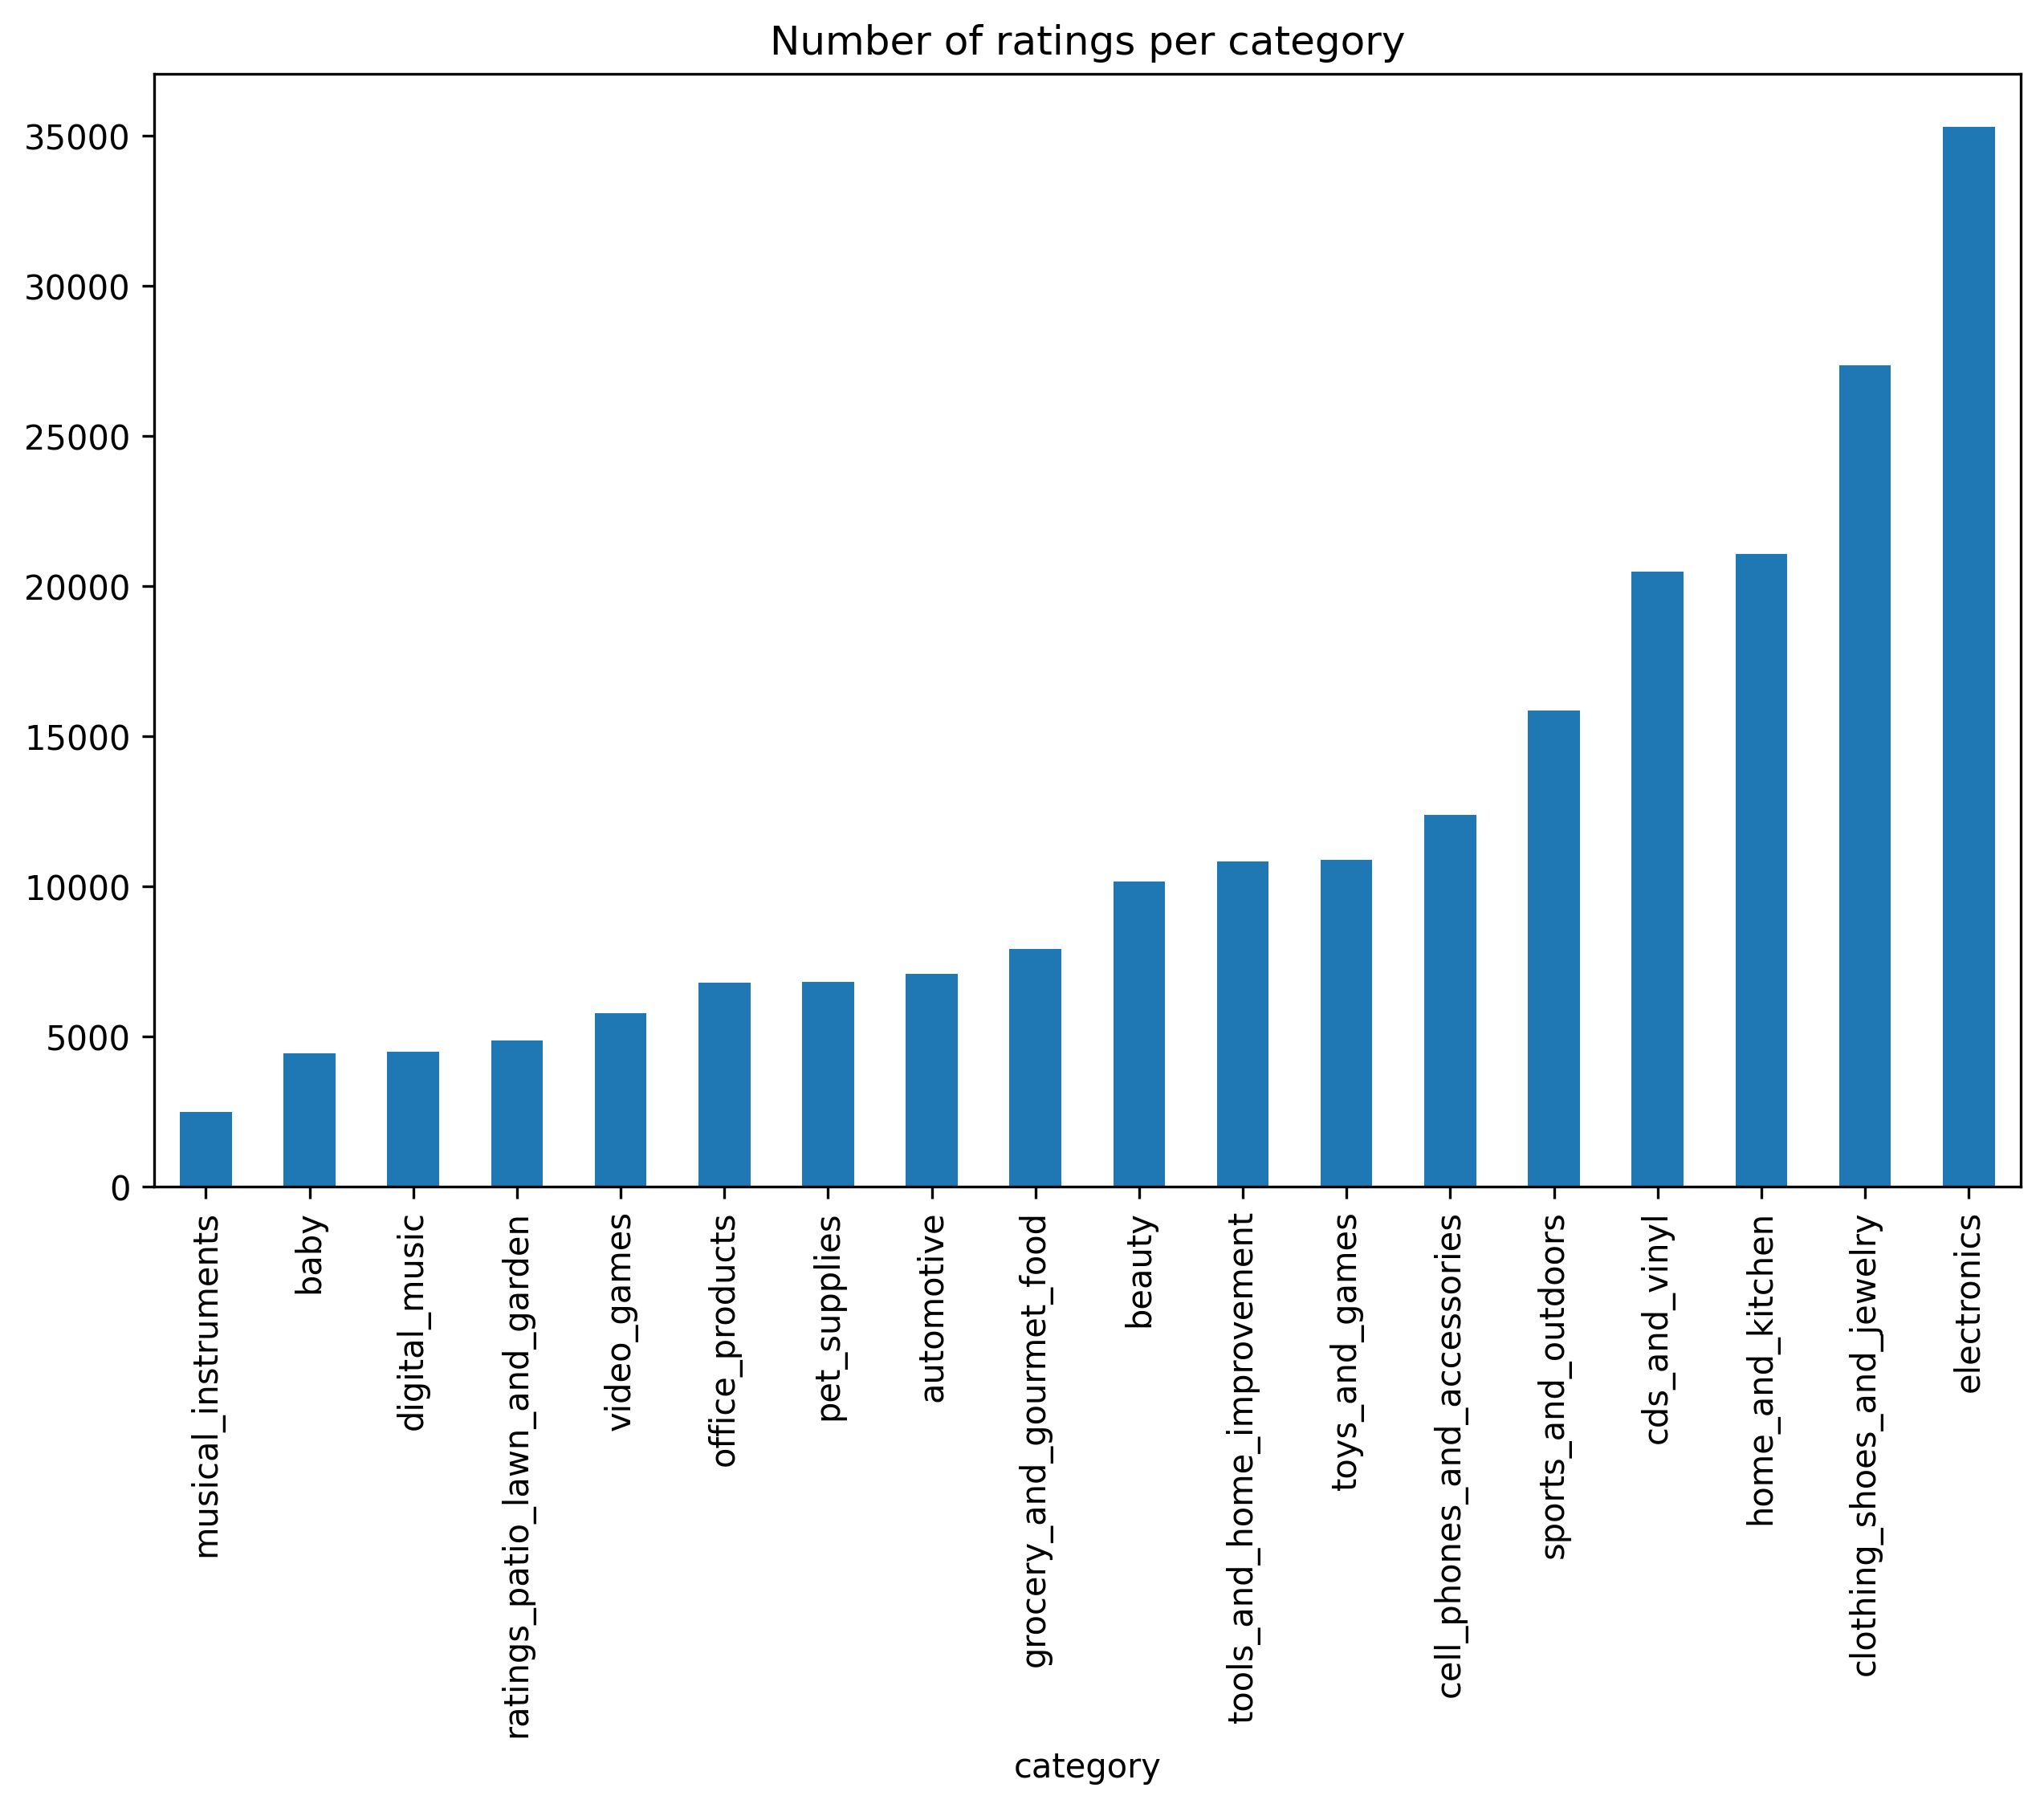

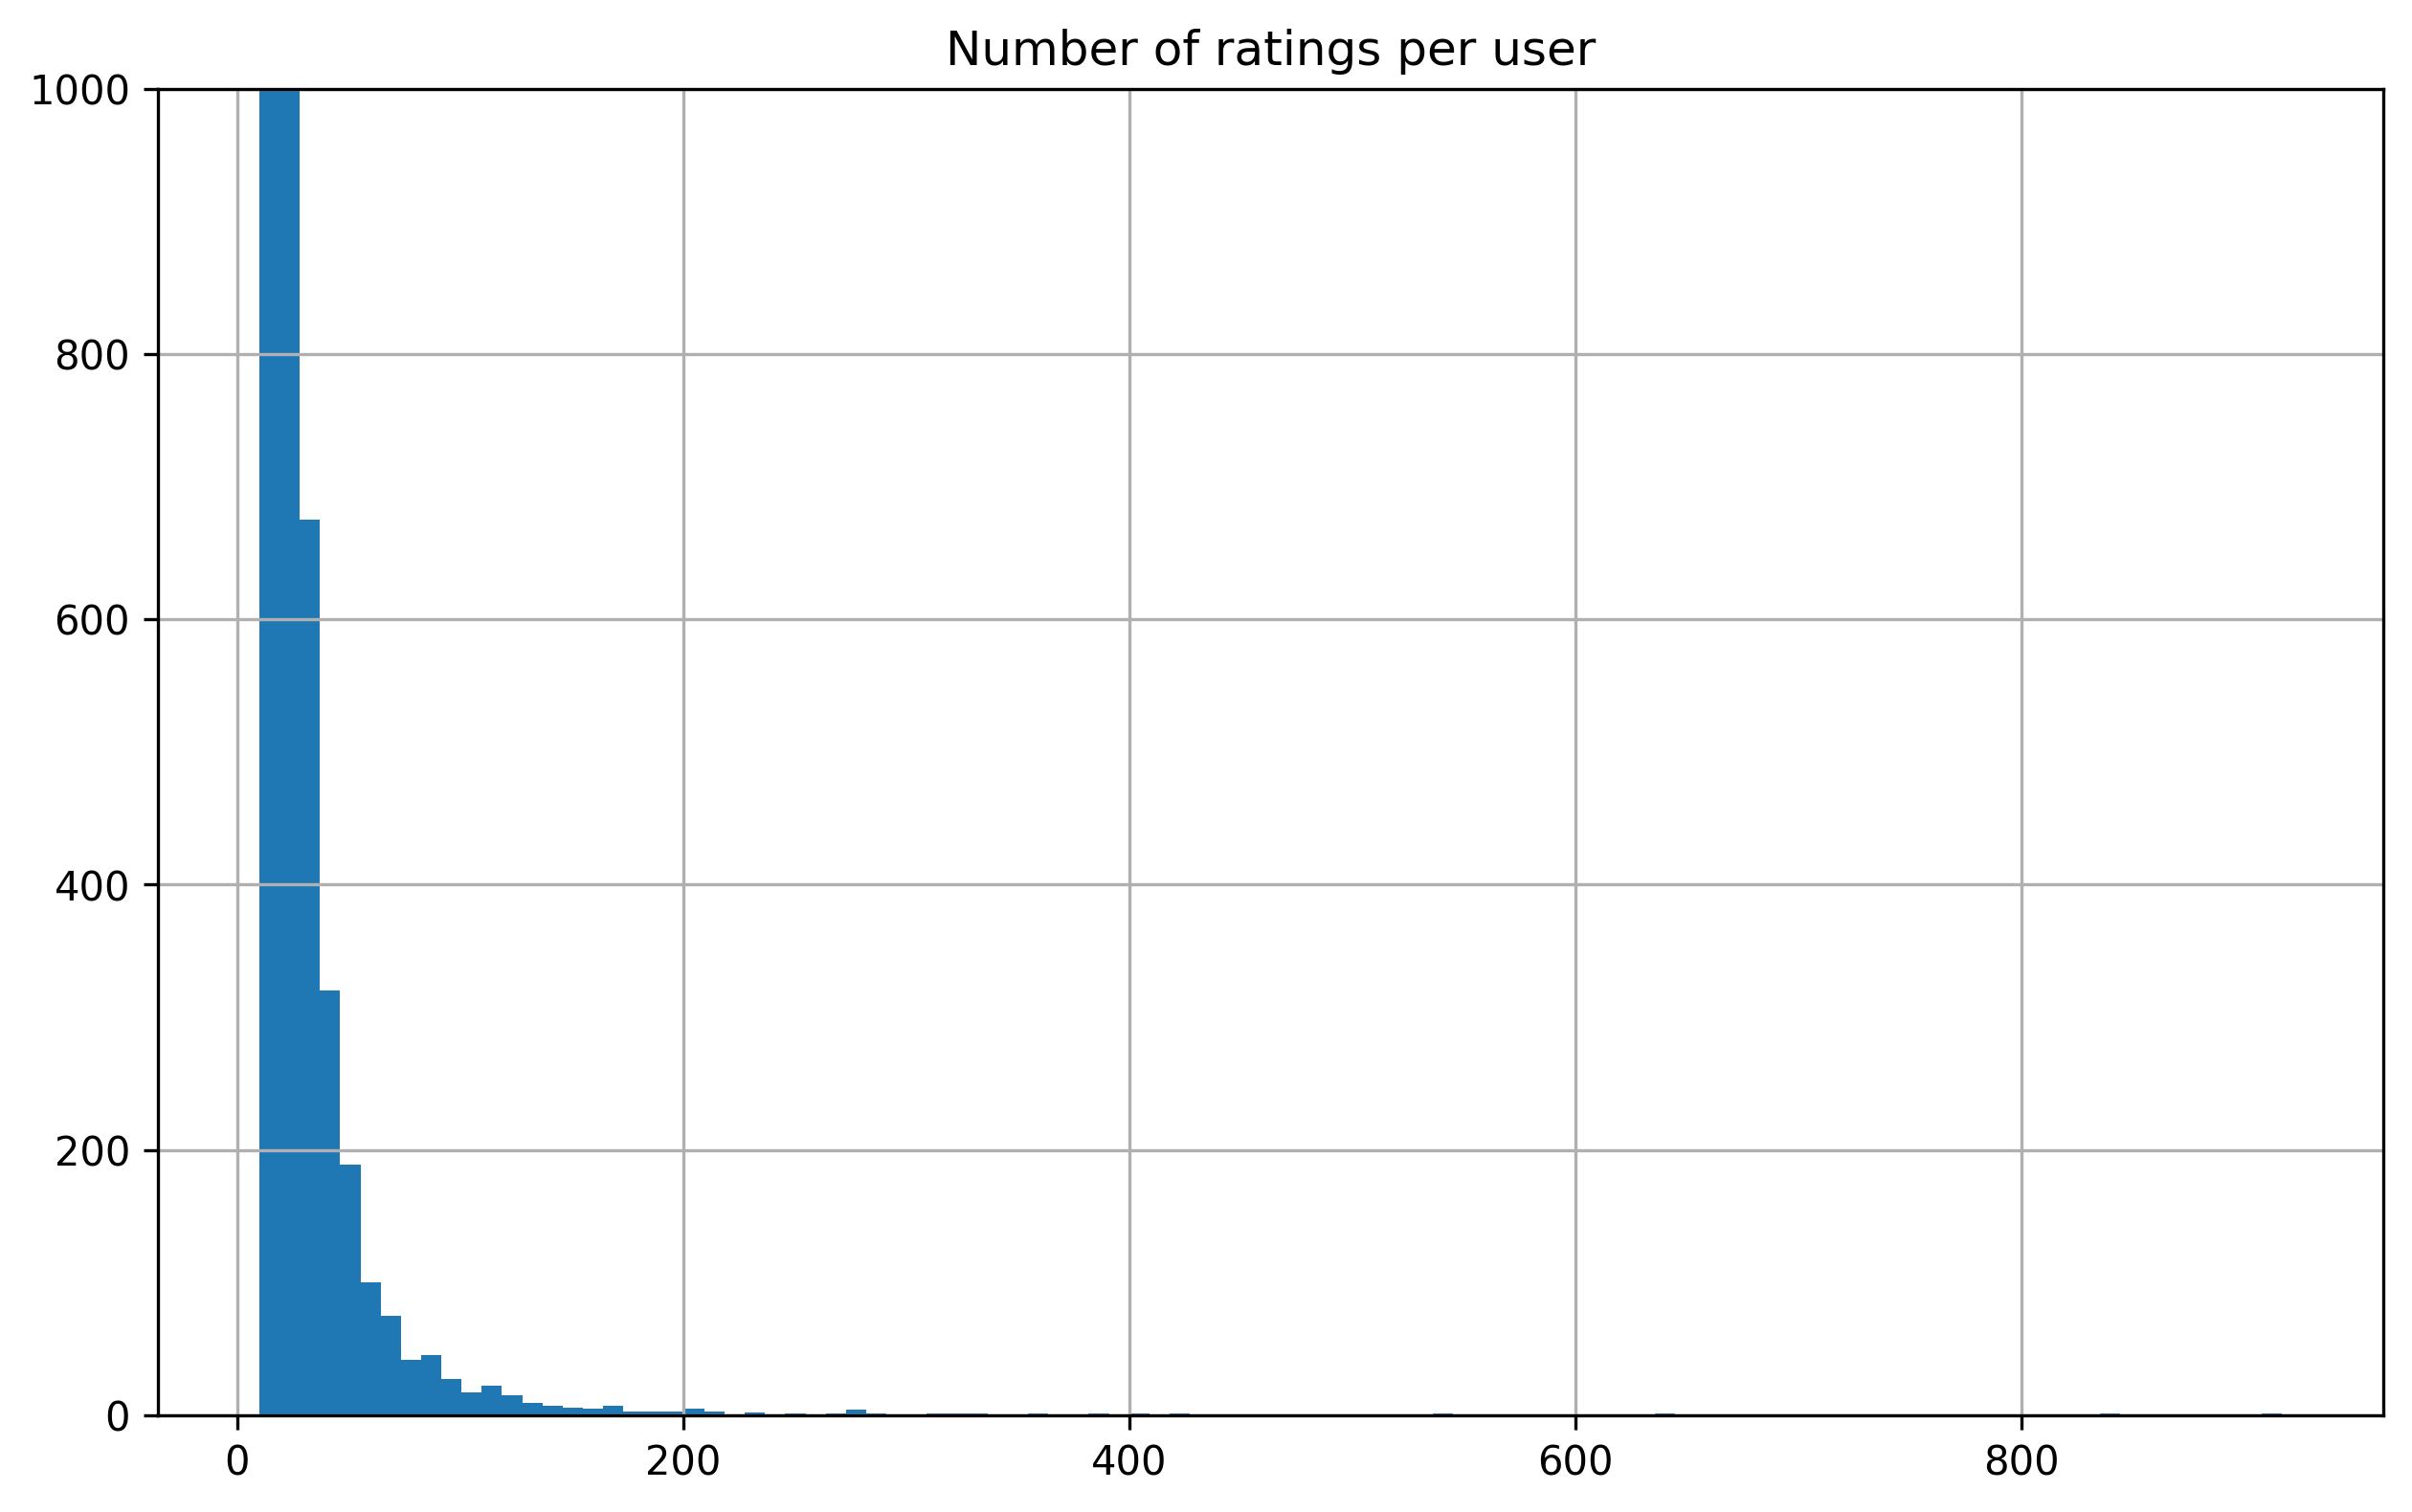

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
df.groupby("category").size().sort_values().plot(kind="bar")
plt.title("Number of ratings per category")
plt.show()

plt.figure(figsize=(10, 6), dpi=300)
df.groupby("user_id").size().hist(bins=100)
plt.ylim(0, 1000)
plt.title("Number of ratings per user")
plt.show()

In [ ]:
# number of unique users
print(df["user_id"].nunique())
# number of unique items
print(df["item_id"].nunique())

df.to_csv(base_dir / "samples" / f"sample_{users_sample_count}.csv", index=False)

10000
161362


In [6]:
from src.data.amazon_reviews import AmazonReviewsDataset
import pandas as pd
from src.models.movielens import RecommendationSystemModel

In [7]:
df = pd.read_csv("data/amazon_reviews/samples/sample_10000.csv")

ds = AmazonReviewsDataset(df)

In [8]:
import torch

from torch import nn
from torch.utils.data import DataLoader
import sys

from collections import defaultdict
import numpy as np

import pandas as pd

from src.data.movielens import MovieLensDataset
from src.data.utils import split_train_test_by_ts

from src.utils import random_seed

from src.models.movielens import RecommendationSystemModel

from src.measures import (
    plot_loss_per_group,
    get_mean_utility_at_k,
    plot_user_utility_per_group,
    calculate_precision_recall,
)

In [9]:
random_seed(0)

In [10]:
train_df, test_df = split_train_test_by_ts(df, ts_col="timestamp", entity_col="user_id", test_size=0.2)

In [11]:
BATCH_SIZE = 32

train_dataset = AmazonReviewsDataset(data=train_df)
test_dataset = AmazonReviewsDataset(data=test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
USERS_COUNT = df["user_id"].nunique()
ITEMS_COUNT = df["item_id"].nunique()

In [13]:
EPOCHS = 2

loss_func = nn.BCEWithLogitsLoss()

recommendation_model = RecommendationSystemModel(
    num_users=USERS_COUNT,
    num_items=ITEMS_COUNT,
    embedding_size=128,
    hidden_dim=256,
    dropout_rate=0.1,
).to(device)

optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)


# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch + 1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)


total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(train_data["users"].to(device), train_data["items"].to(device))
        # Reshape the model output to match the target's shape
        output = output.squeeze()  # Removes the singleton dimension
        ratings = train_data["labels"].to(device)  # Assuming ratings is already 1D


        loss = loss_func(output, ratings)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step count by the actual size of the batch
        step_count += len(train_data["users"])

        # Check if it's time to log progress
        if step_count % log_progress_step == 0 or i == len(train_loader) - 1:  # Log at the end of each epoch
            log_progress(e, step_count, total_loss, log_progress_step, train_dataset_size, losses)
            total_loss = 0

Training on 175427 samples...


02/02 | Step: 175427/175427 | Avg Loss: 0.025186719

In [14]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_df = test_dataset._data.copy()

predictions, targets = recommendation_model.predict(test_loader, device)
test_df["probs"] = 1 / (1 + np.exp(-predictions))

1238it [00:01, 1112.52it/s]


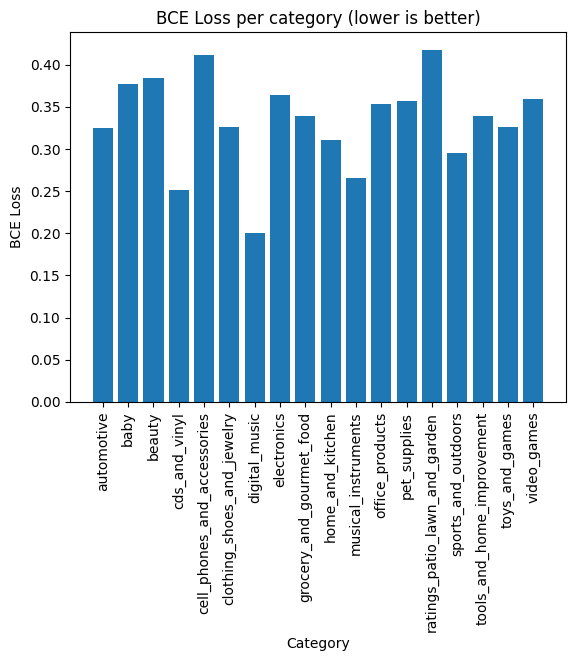

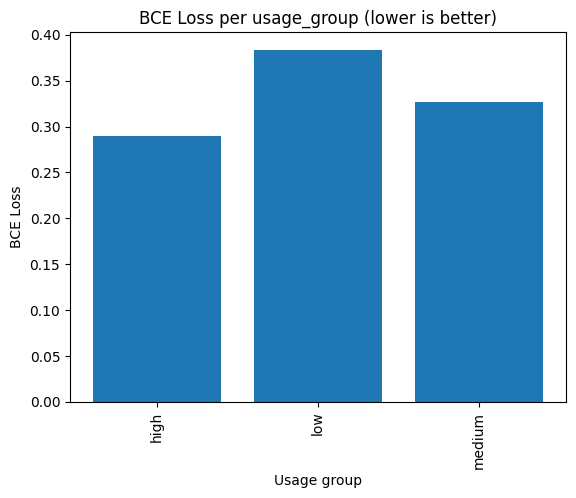

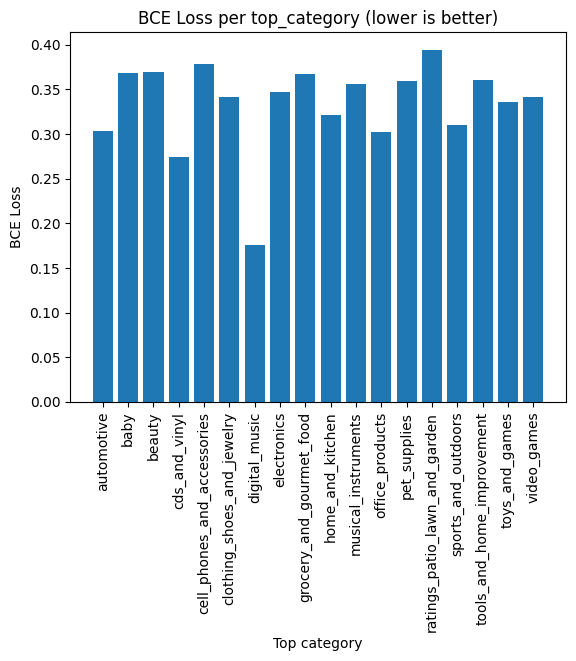

In [15]:
plot_loss_per_group(test_df, "category")
plot_loss_per_group(test_df, "usage_group")
plot_loss_per_group(test_df, "top_category")

Mean utility at k=5: 0.985


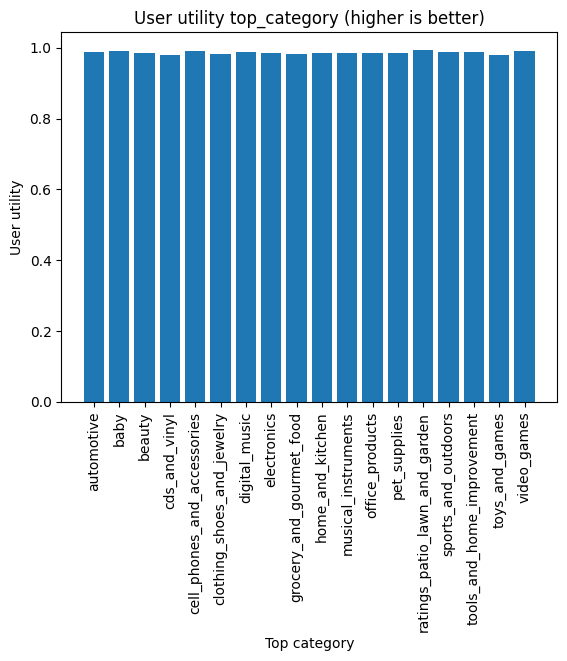

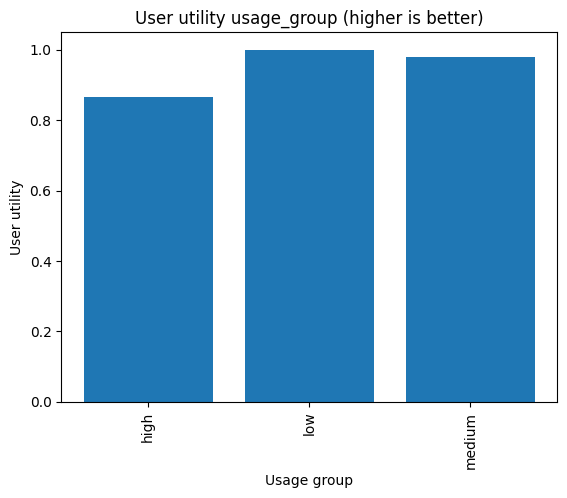

In [16]:
k = 5
print(f"Mean utility at k={k}: {get_mean_utility_at_k(test_df, k):.3f}")

plot_user_utility_per_group(test_df, "top_category", k)
plot_user_utility_per_group(test_df, "usage_group", k)

In [17]:
user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in test_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["items"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model(users, movies)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 10
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall


average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 10: 0.9769
recall @ 10: 0.2375


In [38]:
import math

# sample 10000 items based on the real share of the categories
category_counts = df["category"].value_counts()
category_share = category_counts / category_counts.sum()

sampled_dfs = []
for category, share in category_share.items():
    category_items = df[df["category"] == category]
    sampled_dfs.append(category_items.sample(math.ceil(share * 10000), replace=False))

item_ids = pd.concat(sampled_dfs)["item_id"].unique()

In [ ]:
user_ids = df["user_id"].unique()

all_user_item_pairs = pd.MultiIndex.from_product(
    [user_ids, item_ids], names=["user_id", "item_id"]
).to_frame(index=False)

In [42]:
%load_ext autoreload
%autoreload 2

In [49]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class AmazonReviewsDatasetSimple(Dataset):
    def __init__(
        self,
        data: pd.DataFrame | None = None,
    ) -> None:
        self._data = data

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> dict:
        row = self._data.iloc[idx]
        return {
            "users": torch.tensor(row["user_id"], dtype=torch.long),
            "items": torch.tensor(row["item_id"], dtype=torch.long),
            "ratings": torch.ones(1, dtype=torch.float),
            #"labels": torch.tensor(row["label"], dtype=torch.float),
        }

user_items_df = pd.DataFrame(all_user_item_pairs)
user_items_df["category"] = "n/a"
user_items_df["rating"] = 0
movies_loader = DataLoader(AmazonReviewsDatasetSimple(data=user_items_df), batch_size=BATCH_SIZE, shuffle=False)

predictions, targets = recommendation_model.predict(movies_loader, device)
user_items_df["predictions"] = predictions
user_items_df["probs"] = user_items_df["predictions"].apply(lambda x: 1 / (1 + np.exp(-x)))

3037188it [33:58, 1490.09it/s]


In [71]:
df = pd.read_csv("data/amazon_reviews/samples/sample_10000.csv")

ds = AmazonReviewsDataset(df)
df = ds._data

usage_groups = df.groupby("user_id")["usage_group"].first().reset_index()
top_cats = df.groupby("user_id")["top_category"].first().reset_index()

user_groups = pd.merge(usage_groups, top_cats, on="user_id")

user_groups.sort_values("user_id", inplace=True)
user_groups.to_json("amazon_user_groups.json", orient="records")

In [68]:
np.sort(user_items_matrix.to_numpy()[100])[::-1][:100]

array([0.95387549, 0.95094838, 0.94754485, 0.94727514, 0.94541891,
       0.94107511, 0.93598521, 0.93523813, 0.93399748, 0.93220752,
       0.93166787, 0.9288835 , 0.92848255, 0.92774603, 0.92649768,
       0.92613396, 0.92605446, 0.92601886, 0.92484034, 0.92433399,
       0.92425425, 0.92419023, 0.92330323, 0.92319487, 0.92107907,
       0.92097401, 0.92020139, 0.91859786, 0.91354141, 0.91341478,
       0.91259878, 0.91251901, 0.91249447, 0.91212723, 0.91191155,
       0.91178683, 0.91158381, 0.91098063, 0.91092812, 0.91033585,
       0.9101631 , 0.91001874, 0.90829564, 0.90739812, 0.90692372,
       0.90596096, 0.90568997, 0.90535689, 0.90496921, 0.90454313,
       0.90421192, 0.90418175, 0.90378987, 0.90355398, 0.90340324,
       0.90313894, 0.90310623, 0.90280773, 0.90260097, 0.90257179,
       0.90226782, 0.90193169, 0.90183801, 0.90170906, 0.90160941,
       0.90113424, 0.90107184, 0.90071829, 0.90045283, 0.90034282,
       0.89985892, 0.89975486, 0.89898787, 0.89861305, 0.89860

In [50]:
# export predictions

user_items_df.sort_values(by=["user_id"], ascending=True, inplace=True)
user_items_matrix = user_items_df.pivot_table(index="user_id", columns="item_id", values="probs", fill_value=0.2)
user_items_matrix.reset_index(inplace=True, drop=True)

with open("amazon_predictions.npy", "wb") as f:
    np.save(f, user_items_matrix.to_numpy())